<a href="https://colab.research.google.com/github/ShuYuHuang/CMU_Course_signal/blob/main/04_Medical_Signal/Part_4/Signal_Classification_with_Image_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signal Segmentation with Image Model 主題簡介

雖然ECG或其他訊號通常是一維訊號（先排除通道間的相關性），但這並不意味著它們無法被二維的影像模型處理。事實上，由於網路上關於影像的預訓練模型較多，我們可以利用這些模型的強大能力來分析和預測醫學訊號。透過將訊號轉換為影像，我們可以更好地利用這些預訓練模型。

不同影像模型可以完成不同AI訊號處理、分析，可能包含signal classification, signal segmentation, signal generation等等等。我們這邊會以signal classification 為例，讓各位學習如何以處理圖形用的模型來處理影像分類。

## 🎡教學目標

- 時頻分析工具使用: 使用torchaudio、librosa等工具將訊號進行時頻分析，成為時頻圖。
- 模型建構: 使用Hugginface中預訓練模型做訓練。
- 資料載入: 使用torchaudio及Torch之Datasets Class準備載入資料，包含讀取、前處理等等。
- 模型訓練: 使用hugginface transformer 的Trainer 模組訓練模型並調整超參數以達到最佳效果。
- 模型評估: 使用開源套件計算評估指標，利用測試資料集評估模型效能。

# 📈時頻分析工具使用

這邊我們將介紹使用python一些訊號工具，對訊號做時頻分析，得到2D的時頻圖，這樣就能夠有CNN所倚仗的local connectivity性質，適合使用2D CNN。我們這邊應用在ECG訊號的處裡上，不過其中很多概念與工具都可以用在其他訊號的處理。

課程包含以下內容:
* Up/Down Sampling
* Fast Fourier Transform (FFT)
* Short-Time Fourier Transform (STFT)

# 前置準備

In [ ]:
# For server or other condition that you might have to reinstall numba for librosa
# %pip uninstall -y numba
# %pip uninstall -y llvmlite
# %conda install -y -c numba/label/dev llvmlite
# %pip install git+https://github.com/numba/numba

# For Colab, just install librosa
%pip install librosa

In [2]:
# For everyone
%pip -q install transformers==4.30.0 datasets evaluate accelerate torchaudio torchvision

Note: you may need to restart the kernel to use updated packages.


In [1]:
# 取得ECG單檔
!wget https://github.com/ShuYuHuang/ai4ecg/releases/download/example_data/ecg_example.csv -q

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd  # 導入pandas套件

In [3]:
data = pd.read_csv("ecg_example.csv")  # 讀取CSV文件
sr = 500
signal = data.values[:, 1:]  # 從數據中提取訊號
signal.shape  # 顯示signal的形狀

(5000, 12)

### Torchaudio.Transforms

我們使用torchaudio做為torch原生處理signal 的方法集
- 可以針對toch tensor作用
- 視tensor device位置，可以在 CPU 及 GPU 作用

In [4]:
# 這邊為了後面使用torchaudio的functions，我們將input轉為tensor使用
# torchaudio.transforms 作用的資料shape: (BATCH,) ...,TIME
# 總之最後一個axis必須要是時間，前面如何排列都無所謂，因此，我們從csv檔讀取的資料須經過transpose
x = torch.tensor(signal, dtype=torch.float32).transpose(0,1)

In [5]:
import torchaudio.transforms as T  # 載入處裡方法集

## Re-Sampling

Sampling rate的調整是處理訊號重要的一環，要是要將兩個訊號疊加，但發現兩者雖然sample數相同sampling rage卻不相符則會有錯誤的疊加效果。

Re- sampling有各種方法，對訊號皆有擾動，詳細可參考torch官網參數```resampling_method```:
https://pytorch.org/audio/stable/generated/torchaudio.transforms.Resample.html?highlight=resample#torchaudio.transforms.Resample

預設的就一般訊號分析來講很夠用了。

### Downsample

In [6]:
# Downsample 減少sampling rate,也減少資料點數
downsample = T.Resample(orig_freq = sr, new_freq = sr//4)
x_125 = downsample(x)
print(x.shape, x_125.shape)

torch.Size([12, 5000]) torch.Size([12, 1250])


In [7]:
# 同樣是10秒錄音，在resample後點數會變少
print(len(x.T), len(x_125.T))
# 若是需求的sampling rate剛好是原本的因數，那也可以直接依downsample的倍率做sample
x_125 = x[:, ::4]
print(len(x.T), len(x_125.T))

5000 1250
5000 1250


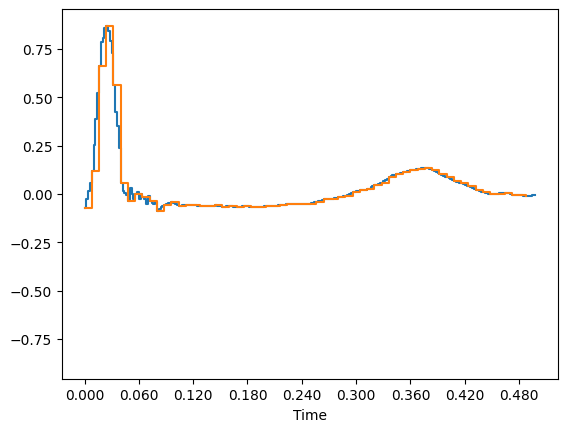

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import librosa.display as ldp

# 從waveplot上可以看到在經過downsample後 有點失真了
ldp.waveshow(x[0, :int(0.5*sr)].numpy(), sr=sr)
ldp.waveshow(x_125[0, :int(0.5*sr//4)].numpy(), sr=sr//4)

### Upsample

In [9]:
# Upsample 增加sampling rate,也增加資料點數
upsample = T.Resample(orig_freq = sr, new_freq = sr*2)
x_1000 = upsample(x)
print(x.shape, x_1000.shape)

torch.Size([12, 5000]) torch.Size([12, 10000])


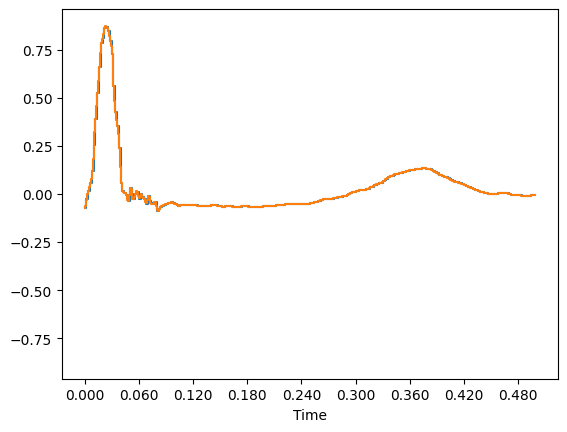

In [10]:
# 在upsample時不會有失真的情況，因為是類似在資料間插值補值
ldp.waveshow(x[0, :int(0.5*sr)].numpy(), sr=sr)
ldp.waveshow(x_1000[0, :int(0.5*sr*2)].numpy(), sr=sr*2)

一般來講upsampling都不存在標準答案，因為就是sampling rate不夠才要補。

Upsampling本身後來在AI領域也變成一個議題，叫Super Resolution，使用訓練好的神經網路模型來做upsampling增加解析度。

## Fast Fourier Transform

分析訊號的成分最常見的方式是頻譜分析，連續訊號可以藉由Fourier Transform得到頻譜，也就是訊號在頻率上的分布。

而對於數位訊號，我們可以藉由Discrete Fourier Transform得到頻譜
$𝐗_k≔\sum\limits_{𝑛=0}^{𝑁−1}𝑥_𝑛 𝑒^{(−𝑗2𝜋𝑘𝑛/𝑁)}$

<img src=https://hackmd.io/_uploads/SyMGrDWY3.png width=800>


Scipy或者其他套件包有提供一些方式做快速的Discrete Fourier Transform，稱為Fast Fourier Transform(FFT)。

若是訊號分析則用Scipy就好，若是要整合到神經網路上可能就得使用Tensorflow或Pytorch內建的fft。

In [11]:
from scipy import fft

這邊因為我們做的是離散的Fourier轉換(時間點數、頻率點數)，若要看到原本單位(seconds, Hz)則需進行轉換。
* 時間: $t=n/f_s$ =>時間刻度 $\Delta t=1/f_s$
* 頻率: $f=k f_s/N$ =>頻率刻度 $\Delta f=f_s/N$

N為參與FFT的時間點數量，$f_s$則是sampling rate。

**e.g. 假設我們有一段訊號，其採樣率為 200Hz，我們使用 500 點 FFT 進行頻譜分析，我們想要取得 0.2Hz~1.2Hz 這個頻段的頻率響應(頻譜數值)如何選取index?**

首先，我們需要計算頻譜的採樣間隔。

頻率刻度計算考慮sampling rate $f_s = 200Hz，FFT點數N = 500$，因此 $\Delta f = 200/500 = 0.4Hz$。

其次，我們需要計算 0.2Hz~1.2Hz 這個頻段的index k 值且$k = f / \Delta f $
，因此 計算最低與最高k值為：

- 最低 = 0.2Hz / 0.4Hz = 0.5
- 最高 = 1.2Hz / 0.4Hz = 3

因此，我們需要篩出頻譜中 k 值為1\~3的頻譜，得到[0.4, 0.8, 1.2] Hz的頻率響應。

In [12]:
signal.shape

(5000, 12)

In [13]:
# 使用scipy.fft.fft可以對訊號做fft
#  'x' - 資料
#  'n' - FFT點數，通常不指定，預設為資料總點數
# 記得做完Fourier Transform後m, 出來都是複數 (預設為complex64格式)
# (不管是continuous/discrete/fast Fourier Transfor)
N = len(signal)
x_f = fft.fft(signal[:N,0])  # TIME => FREQUENCY (only FREQUENCY/2 range is valid)
x_f.shape

(5000,)

Text(0.5, 0, 'frequency(Hz)')

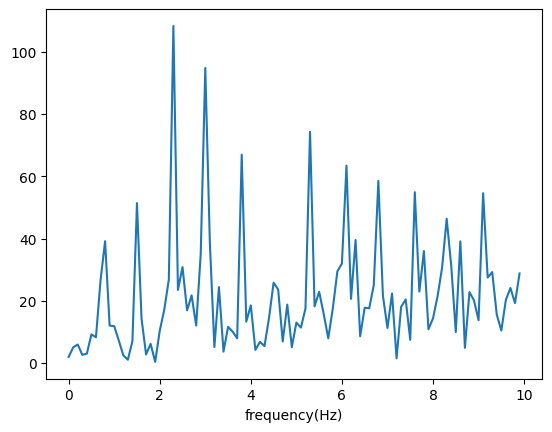

In [14]:
frequency = np.linspace(0, sr, N)
max_f = 10  # 設定想看到的最大頻率 (Hz)
max_k = int(max_f*N/sr)  # 轉成k

# 通常我們是看這個複數的magnitude, 取absolute就可以做到
plt.plot(frequency[:max_k], abs(x_f[:max_k]))
plt.xlabel("frequency(Hz)")

在頻譜圖中我們可以看到較為高峰的點就表示訊號有較多該頻率成分。

我們可以試著把做頻譜的時間縮點一點，來看看最前面一段的頻譜

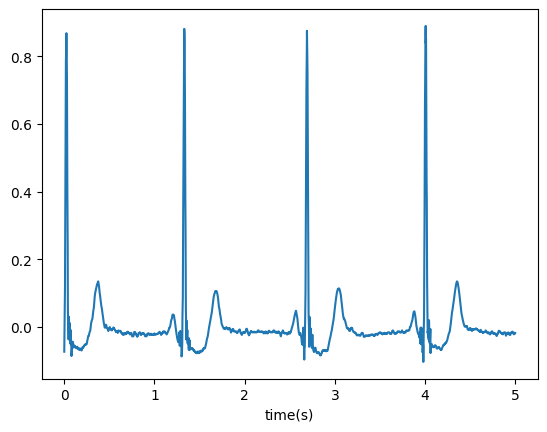

Text(0.5, 0, 'frequency(Hz)')

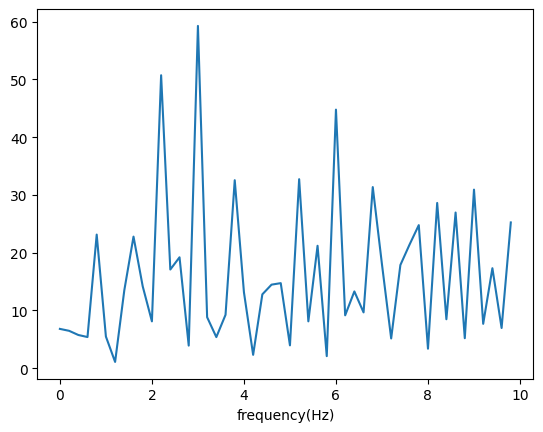

In [15]:
N1 = int(0*sr)
N2 = int(5*sr)
plt.plot(np.arange(N1, N2)/sr, signal[N1:N2, 0])
plt.xlabel("time(s)")
plt.show()
x_f2 = fft.fft(signal[N1:N2, 0])
frequency2 = np.linspace(0, sr, N2-N1)
max_k2 = int(max_f*(N2-N1)/sr)  # 轉成k
plt.plot(frequency2[:max_k2], abs(x_f2[:max_k2]))
plt.xlabel("frequency(Hz)")

我們可以看到較前面一小段的頻譜跟一整段的峰出現頻率差不多，因為心跳隨著時間有穩定的節奏性。

Text(0.5, 0, 'frequency(Hz)')

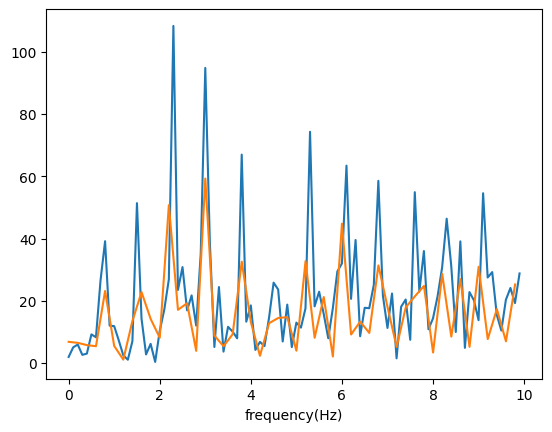

In [16]:
plt.plot(frequency[:max_k], abs(x_f[:max_k]))
plt.plot(frequency2[:max_k2], abs(x_f2[:max_k2]))
plt.xlabel("frequency(Hz)")

擷取與整段對比:
* 整段時長較長，堆積出的能量比較高

## Short-Time Fourier Transform

若是想統計出一段整段的頻率分析，則這個FFT就夠用了，但通常想知道的是在每個時間點頻率分布長什麼樣子就必須要做時頻分析。

時頻分析中最常見的方式就是Sort-Time Fourier Transform:
1. Windowing
2. 個別做頻譜

公式:

$𝑋[q,k] = \sum\limits_{𝑛^′=⌈−𝑁/2⌉}^{⌈𝑁/2⌉−1}𝑥[𝑛^′+𝑞𝐻]𝑤[𝑛^′] 𝑒^\frac{−𝑗2\pi𝑘𝑛^′}{𝑁}$

* q- 每個window的離散時間點
* k- 離散頻率點
* n'- 原訊號的離散時間點
* N- window內FFT點數，同時是window size
* H- hop size，每個window離多少n'
* w- windowing function
* x- signal

<img src=https://hackmd.io/_uploads/S1K7SPZK3.png width = 600>


我們這邊使用```torchaudio.transforms.Spectrogram```來做時頻分析

In [17]:
# 使用T.Spectrogram可以形成一個做stft的function
#  'n_fft' - FFT點數，同時是window長度，這邊一定要指定，預設400，可根據自己想看到的頻率範圍調整
#  'hop_length' - 每個window間要跳多長
#  'window_fn' - windowing function，預設是 'torch.hann_window'
# 出來是Spectrogram, type由input type指定

stft = T.Spectrogram(n_fft=128) # Calculate spectrogram with STFT
S = stft(x)  # (BATCH,) CHANNELS, TIME => (BATCH,) CHANNELS, FREQUENCY, TIME
S.shape

torch.Size([12, 65, 79])

In [18]:
# 可以看出，我們使用STFT可生出一個K x Q 的矩陣
print(S.shape)
print(type(S))
print(S.dtype)

torch.Size([12, 65, 79])
<class 'torch.Tensor'>
torch.float32


## Plot Spectrogram

使用```librosa.display.specshow```可以畫出頻譜圖

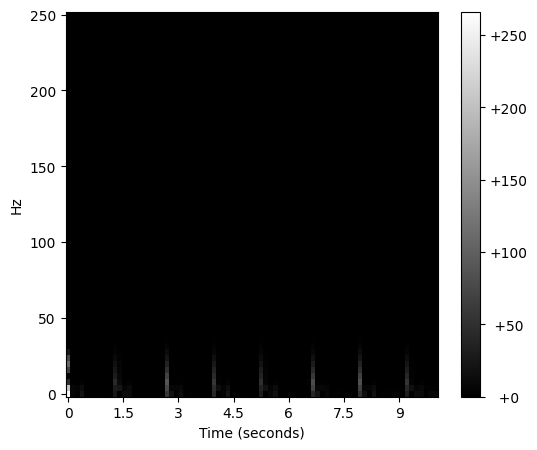

In [19]:
# 使用librosa.display.specshow畫出Spectrogram
#  'data' - Spectrogram
#  'sr' - sampling rate
#  'x_axis' - x 軸刻度單位
#  'y_axis' - y 軸刻度單位，預設為 'hz'，若要使用log scale可以用 'log'
#  'cmap' - color map
#  'hop_length' - hop length，要跟著前面
#  'n_fft' - FFT點數，要跟著前面

plt.figure(figsize=(6, 5))
ldp.specshow(S[0].numpy(),
             n_fft=128,
             hop_length=128//2,
             sr=sr,
             x_axis="s",
             y_axis="hz",
             cmap="gray")
plt.colorbar(format="%+4.f")
plt.show()

若全圖檢視可以看到所有包含的頻率，但其中Y軸的scale有點太大使得較低頻較有資訊的部分看不見，可以轉而使用log scale frequency

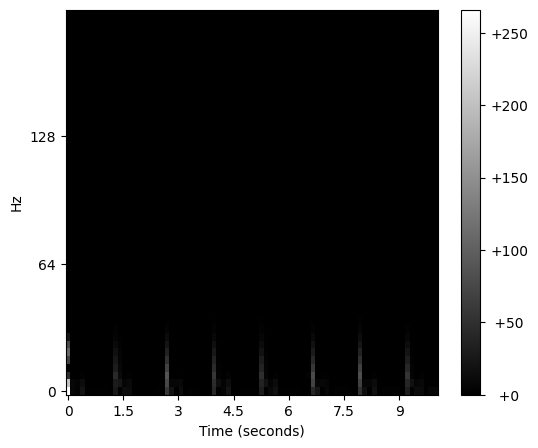

In [20]:
plt.figure(figsize=(6, 5))
ldp.specshow(S[0].numpy(),
             n_fft=128,
             hop_length=128//2,
             sr=sr,
             x_axis="s",
             y_axis="log",
             cmap="gray")  # **
plt.colorbar(format="%+4.f")
plt.show()

結果如果對比不夠明顯，可以使用```librosa.power_to_db```轉成分貝來看

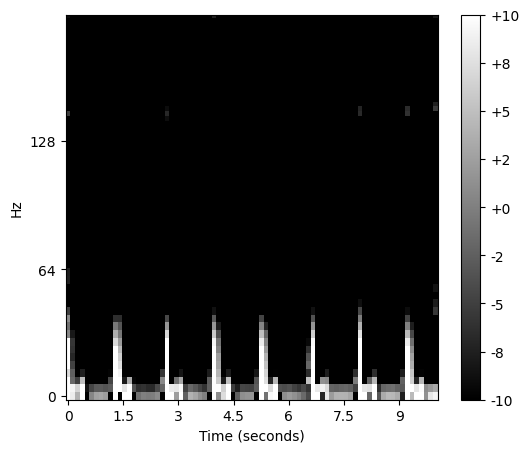

In [21]:
S_db = librosa.power_to_db(abs(S[0]).numpy()) # **
plt.figure(figsize=(6, 5))
ldp.specshow(S_db,
             n_fft=128,
             hop_length=128//2,
             sr=sr,
             x_axis="s",
             y_axis="log",
             cmap="gray")  # **
plt.colorbar(format="%+2.f")
plt.clim([-10, 10])  # **
plt.show()

這邊就是曹昱老師講音訊處裡AI時的前置步驟，feature extraction那一塊做的事情

<img src=https://hackmd.io/_uploads/BJ_UkJ3K2.png width=300>

(source: 曹老師AIA醫療專班課程)

In [22]:
# 使用 power=None 使得Spectrogram 返回完整complex number頻譜 torch.complex64
stft = T.Spectrogram(n_fft=128, power=None) # Calculate spectrogram with STFT
S_c = stft(x)  # (BATCH,) CHANNELS, TIME => (BATCH,) CHANNELS, FREQUENCY, TIME
S_c.dtype

torch.complex64

可以使用它的 .real 叫出實數部分、用 .imag 叫出虛數部分

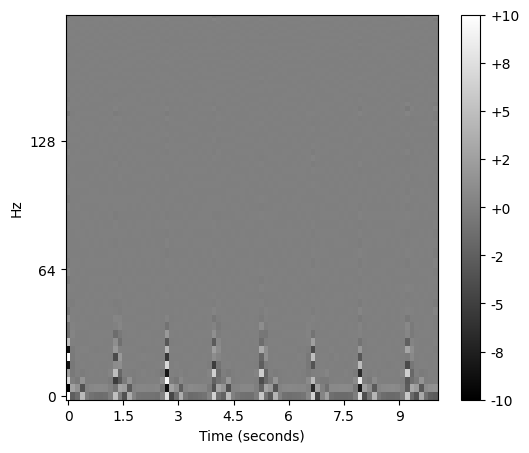

In [23]:
plt.figure(figsize=(6, 5))
ldp.specshow(S_c[0].real.numpy(),
             n_fft=128,
             hop_length=128//2,
             sr=sr,
             x_axis="s",
             y_axis="log",
             cmap="gray")  # **
plt.colorbar(format="%+2.f")
plt.clim([-10, 10])  # **
plt.show()

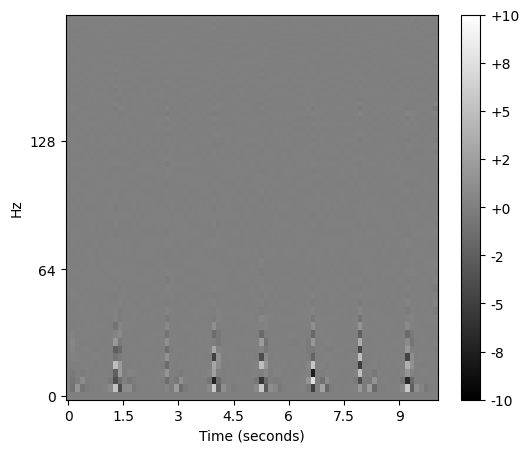

In [24]:
plt.figure(figsize=(6, 5))
ldp.specshow(S_c[0].imag.numpy(),
             n_fft=128,
             hop_length=128//2,
             sr=sr,
             x_axis="s",
             y_axis="log",
             cmap="gray")  # **
plt.colorbar(format="%+2.f")
plt.clim([-10, 10])  # **
plt.show()

使用 ```abs```可以將原本complex number的 amplitude部分抓出來，就等於```power=1```的作法，稱為amplitude spectrum

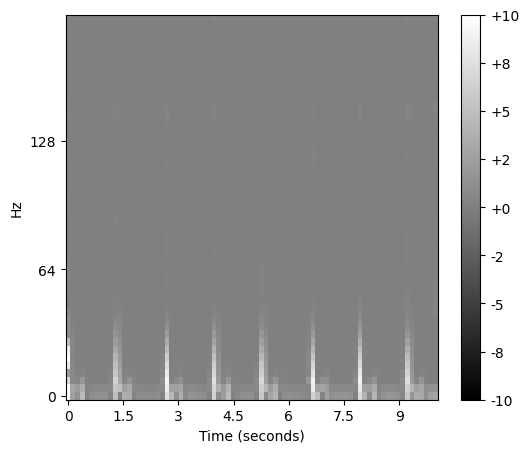

In [25]:
plt.figure(figsize=(6, 5))
ldp.specshow(abs(S_c[0]).numpy(),
             n_fft=128,
             hop_length=128//2,
             sr=sr,
             x_axis="s",
             y_axis="log",
             cmap="gray")  # **
plt.colorbar(format="%+2.f")
plt.clim([-10, 10])  # **
plt.show()

使用 ```torch.angle```可以將原本complex number的相位 (實數與虛數的夾角)抓出來，得到phase spectrum

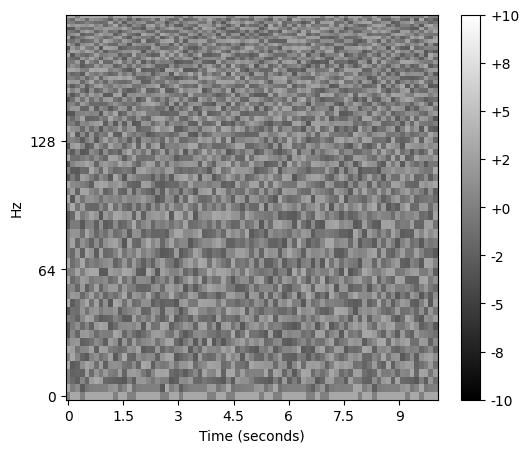

In [26]:
plt.figure(figsize=(6, 5))
ldp.specshow(torch.angle(S_c[0]).numpy(),
             n_fft=128,
             hop_length=128//2,
             sr=sr,
             x_axis="s",
             y_axis="log",
             cmap="gray")  # **
plt.colorbar(format="%+2.f")
plt.clim([-10, 10])  # **
plt.show()

訊號處理中比較常看amplitude spectrum或者power spectrum，所以常以這兩種做為CNN的input。但也可嘗試將phase也加入input，增加資訊。

## Augmentation  (還在想要不要加)

In [ ]:
# from torchaudio.sox_effects import apply_effects_tensor
# resample = 100
# effects = []
# if resample:
#     effects.extend(
#         [
#             ["lowpass", f"{resample // 2}"],
#             ["rate", f"{resample}"],
#         ]
#     )
# x_, sr_ = apply_effects_tensor(x, sample_rate=500, effects=effects)
# S = transform(x_).cuda()

In [ ]:
# plt.plot(np.linspace(0, 10, len(x_.T)), x_.T[:,0])
# plt.plot(np.linspace(0, 10, len(x.T)), x.T[:,0])

# 🤗模型建立

使用與醫療影像同樣的2D CNN model 我們可以針對訊號的頻譜建構classification模型

In [29]:
from transformers import AutoImageProcessor
# checkpoint = "google/efficientnet-b6"
checkpoint = "facebook/convnext-tiny-224"
# checkpoint = "microsoft/beit-large-patch16-512"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [30]:
labels = ['N', 'O', 'A', '~']
label2id = {c: c_idx for c_idx, c in enumerate(labels)}
id2label = {str(c_idx): c for c_idx, c in enumerate(label2id)}

In [31]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


第一次使用hugginface的 `AutoModelXXXX.from_pretrained` 預設會將model儲存在暫存資料夾`$HOME/.cache/huggingface`中

可以使用系統指令`du`來看到底用了多少容量

In [42]:
# -h 可以顯示出常見單位 Byte 作為大小，-d 可以指定表列幾層資料夾
!du -h $HOME/.cache/huggingface/hub/ -d 1

110M	/home/studio-lab-user/.cache/huggingface/hub/models--facebook--convnext-tiny-224
110M	/home/studio-lab-user/.cache/huggingface/hub/


可先嘗試將一個channel的spectrogram放入model。

注意這邊要對model做repeat，直到有三個channel，對上model的RGB三個channel。

In [45]:
# 這邊試著把其中一個channel的Spectrogram丟進Model
# S 的 3 個 axis: CH (12), FREQUENCY, TIME
# S[0] 的 2 個 axis: FREQUENCY, TIME
# Model 的 4 個 axis 需求shape為: BATCH, CH (3), WIDTH, HEIGHT
# => 前面多一個axis, 在channel那邊需要
x = S[0].repeat(1, 3, 1, 1)
with torch.no_grad():
    logits = model(x).logits
print(logits)

tensor([[ 0.2065,  0.1225,  0.0961, -0.2401]])


# 🗃️資料載入

同Part 2，我們使用CinC2017比賽資料集的一部分來做為訓練資料

在colab上要先下載資料集

In [ ]:
# download dataset
!wget https://github.com/TA-aiacademy/CMU_Course/releases/download/signal_data/cinc_data.tar.gz
!mkdir data
!tar -xf cinc_data.tar.gz -C ./data

下面針對這種spectrogram，我們做一個 Dataset class。

其中會有些參數是考量這筆資料裡面的一些已知內容，例如最小長度，sampling rate等等。

在這個例子中我們只使用單channel的spectrogram。

那我們已知這個資料集中只有一個channel，所以只要取"lead"這個channel就好。

In [46]:
import os
import json
import pandas as pd
import torch
from torch.utils.data import Dataset
import torchaudio.transforms as T  # 載入處裡方法集

# Data SPECS:
#   sampling rate: 300
#   mininal length: ~9 seconds
#   maximal length: ~60 seconds
#   value range: -7360 ~ 7636
class SpectogramDataset(Dataset):
    def __init__(self,
        data_root,
        annot_file,
        channel="lead",
        class_names=["N", "O", "A", "~"],
        n_fft=128,
        min_len=300*9,
        transforms=None):
        """
        Args:
            data_root (str): root directory of the dataset
            annot_file (str): filename of the annotation file, ".json" format
            channel (list): target lead name
            class_names (list): list of class names for mapping class name to class id
            n_fft (int): point of fft for making spectrogram
            min_len (int): length of the output signal, truncated from each full signal

        """
        # Read the label file as list of dictionary
        with open(annot_file,"r") as f:
            self.labels=json.load(f)

        # List the signal files
        self.data_root = data_root
        self.signal_paths = [
            os.path.join(data_root, elem["csv"]+".csv")
            for elem in self.labels
        ]

        self.class_map = {n: i for i, n in enumerate(class_names)}

        print("dataset class map: ", self.class_map)
        # Set the target leads for the dataset
        self.channel = channel
        # Set the specs of the dataset
        self.min_len = min_len
        # Specify method of spectral analysis
        self.spectral_analysis = T.Spectrogram(n_fft=n_fft)

        # Import image processor if there is one
        self.transforms = transforms

    def __len__(self):
        return len(self.labels)

    def get_min_len(self):
        # Calculate minimal length of signal
        # in case you don't know it in advance
        signal_len = [
            len(self.load_file(file))
            for file in self.signal_paths
        ]
        self.min_len = min(signal_len)
        return self.min_len

    def truncate(self, x):
        # Truncate minimal length from full signal
        start = np.random.randint(0, len(x)-self.min_len)  # get a start point of sampling
        return x[start:start+self.min_len]

    def load_file(self, file_name):
        # Load singnal form file
        return pd.read_csv(file_name)[self.channel].values

    def __getitem__(self, idx):
        # Get one singal and label specific to the given index
        signal_path = self.signal_paths[idx]  # get data file path
        signal = self.load_file(signal_path)  # load signal
        signal = self.truncate(signal)  # get an equal length form file
        class_name = self.labels[idx]["choice"]  # get label
        class_id = self.class_map[class_name]  # map the label to number

        # Put data, label into torch tensor
        signal = torch.tensor(signal, dtype=torch.float32)
        class_id = torch.tensor(class_id, dtype=torch.long)

        # Get Spectrogram (repeat 3 times for the CNN model)
        signal = self.spectral_analysis(signal).repeat(3, 1, 1)
        signal = signal / signal.max() * 255

        if self.transforms:
            signal = self.transforms(signal)

        return {'pixel_values': signal, 'label': class_id}

In [47]:
# 這邊皆可使用torchvision來幫忙做前處裡
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
)

# 使用該模型當初訓練時的 mean 跟 STD對數值Normalize
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

# 使用該模型當初訓練時的長寬來做resize
size = (image_processor.size["shortest_edge"], image_processor.size["shortest_edge"])
resize = Resize(size, antialias=True)

# 組合成連續function
transforms = Compose(
    [
        resize,
        normalize,
    ]
)


train_ds = SpectogramDataset(
    "./data/csv_train",
    annot_file="./data/annot_train.json",
    transforms=transforms)
test_ds = SpectogramDataset(
    "./data/csv_test",
    annot_file="./data/annot_test.json",
    transforms=transforms)

dataset class map:  {'N': 0, 'O': 1, 'A': 2, '~': 3}
dataset class map:  {'N': 0, 'O': 1, 'A': 2, '~': 3}


In [48]:
# 確認dataset讀得出來，以及他的shape
item = next(iter(test_ds))
item["pixel_values"].shape # [batch, ]

torch.Size([3, 224, 224])

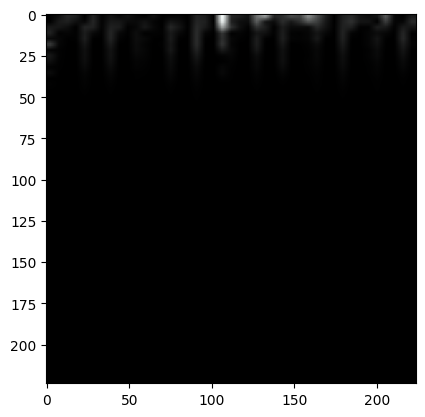

In [49]:
# 畫一個出來試試看是否OK
# 這邊因為做了圖形大小的scaling，所以就不以時頻圖去看而是直接當一般影像看待
x = item["pixel_values"].numpy().transpose(1,2,0)
x = (x-x.min())/(x.max()-x.min())
plt.imshow(x)

# 🏭模型訓練

有模型及資料準備開始訓練

## 訓練參數

下面解說幾種常用參數類型前面講過不過我這邊再附一次:

1. 訓練參數相關(主要做ablation study會調控的參數):
    - per_device_train_batch_size: 每個裝置訓練的Batch size, Hugginface分散式運算每個GPU的batch大小
    - learning_rate: 學習率
    - weight_decay: L2 normalization 比率，使weight不至於變化太大
2. 訓練內容評估:
    - num_train_epochs: EPOCH數
    - evaluation_strategy: 多久評估一次，有 'no'、'epoch'、'step'可選，若選step必須指定eval_steps
3. 模型儲存
    - save_strategy: 多久儲存一次，有 'no'、'epoch'、'step'可選，若選step必須指定save_steps
    - save_total_limits: 最多存幾個 model ，請設定以避免硬碟空間爆掉
    - metric_for_best_model: 決定最佳模型的計算指標，通常是loss或eval_loss，越小越好
    - load_best_model_at_end: 是否在訓練結束時載入最佳模型
4. 輸出內容設定
    - output_dir: 輸出目錄
    - overwrite_output_dir: 是否覆蓋已有目錄及內容
    - logging_steps: 紀錄訓練內容的步數(每X步記錄一次)
5. 其他:
    - remove_unused_columns: 是否刪除沒用到的模型forward輸出值(key+value)，若設為 True 常會使一些判斷項無法運作

In [50]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="my_model_exercise",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy")

## Trainer物件

接下來組建模型Trainer object，可以拿來train模型、evaluate、inference。

其中需要代入一些object來initiate這個trainer object。
- model: 必須要式HF model
- args: 剛剛的TrainingArguments object
- train_dataset: 訓練集，HF dataset物件
- eval_dataset: 驗證集，HF dataset物件
- compute_metrics: 評估指標function，可加可不加，若不加則記錄 loss 跟 eval_loss 而已

In [54]:
import evaluate

mymetric = evaluate.load('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return mymetric.compute(predictions=predictions.argmax(1), references=labels)

In [52]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

In [53]:
# 版本問題會跳出很多不必要訊息，我們可以拿掉
from transformers.integrations import MLflowCallback
trainer.remove_callback(MLflowCallback)

trainer.train() # 開始訓練模型

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epoch,Training Loss,Validation Loss


TrainOutput(global_step=25, training_loss=1.0510165405273437, metrics={'train_runtime': 23.1984, 'train_samples_per_second': 34.485, 'train_steps_per_second': 1.078, 'total_flos': 2.01032220082176e+16, 'train_loss': 1.0510165405273437, 'epoch': 1.0})

## Reference (好像應該丟些EEG的)
* M. Mueller, Fundamentals of Music Processing, Springer 2015
* 前述課本附Notebook- https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html
* Librosa官網- https://github.com/librosa/librosa
* Acoustics for Musicians and Artists, by Miller Puckette, UCSD
* Youtube 熱門音訊AI課程- https://github.com/musikalkemist/AudioSignalProcessingForML